TODO:
- [ ] Grad flow for different layers (Conv, RNN, etc.)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from boring_utils.utils import *

%matplotlib inline 
init_graph()
device = get_device()
set_seed(42)

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../model/uvadlc_l3/"

# Fashion MNIST

In [3]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"

# Files to download
pretrained_files = [
    "FashionMNIST_elu.config", "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"
]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

# Implement Activation Functions

In [4]:
act_fn_by_name = {}

## Sigmoid and Tanh

In [5]:
class Sigmoid(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
    '''
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

act_fn_by_name['sigmoid'] = Sigmoid


class StableSigmoid(nn.Module):
    '''
    Check Mu Li's d2l
    '''
    def forward(self, x):
        return 4 / (1 + torch.exp(-x)) - 2

act_fn_by_name['stablesigmoid'] = StableSigmoid


class Softmax(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Softmax.html#torch.nn.Softmax
    '''
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        exp_x = torch.exp(x)
        sum_exp_x = torch.sum(exp_x, dim=self.dim, keepdim=True)
        return exp_x / sum_exp_x
        # return F.softmax(x, self.dim, _stacklevel=5)

# act_fn_by_name['softmax'] = Softmax  # let's skip this rn :(


class Tanh(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Tanh.html#torch.nn.Tanh
    '''
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanh'] = Tanh


class Tanhshrink(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.Tanhshrink.html
    '''
    def forward(self, x):
        return x - (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanhshrink'] = Tanhshrink


class Softplus(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Softplus.html#torch.nn.Softplus
    '''
    def __init__(self, beta=1, threshold=20):
        super().__init__()
        self.beta = beta
        self.threshold = threshold

    def forward(self, x):
        softplus =  1/self.beta * torch.log(1 + torch.exp(self.beta * x))
        return torch.where(x > self.threshold, x, softplus)

act_fn_by_name['softplus'] = Softplus


class Mish(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Mish.html#torch.nn.Mish
    '''
    def forward(self, x):
        soft_plus = torch.nn.functional.softplus(x)
        tanh_x = torch.tanh(soft_plus)
        return x * tanh_x

act_fn_by_name['mish'] = Mish

## ReLU and Swish

In [6]:
class ReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ReLU.html#torch.nn.ReLU
    '''
    def forward(self, x):
        # return torch.max(0, x)
        return x * (x > 0).float()

act_fn_by_name['relu'] = ReLU


class LeakyReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU
    '''
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.neg_slop = negative_slope
        
    def forward(self, x):
        return torch.where(x > 0, x, self.neg_slop * x)

act_fn_by_name['leakyrelu'] = LeakyReLU


class PReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.PReLU.html#torch.nn.PReLU
    '''
    def __init__(self, num_parameters=1, init=0.25):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_parameters).fill_(init))

    def forward(self, x):
        return torch.where(x > 0, x, self.weight * x)

# act_fn_by_name['prelu'] = PReLU  # also skip this :(


class ELU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ELU.html#torch.nn.ELU
    '''
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.alpha * (torch.exp(x) - 1))

act_fn_by_name['elu'] = ELU
    

class SiLU(nn.Module):
    '''
    https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html
    '''
    def forward(self, x):
        return x * torch.sigmoid(x)

act_fn_by_name['silu'] = SiLU


class GELU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.GELU.html#torch.nn.GELU
    '''
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                np.sqrt(2 / torch.pi) * (x + 0.044715 * torch.pow(x, 3))
                )
            )

act_fn_by_name['gelu'] = GELU

In [22]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"


def vis_act_fn(act_fn, ax, x, lims=(-1.5, 2.5)):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(*lims)


def vis_act_fn_softmax(act_fn, ax, x, lims=(-1.5, 2.5)):
    # Create a 2D input tensor by stacking x with itself
    x_2d = torch.stack([x, x], dim=1)
    
    # Run activation function
    y = act_fn(x_2d)
    
    # Push x and y back to cpu for plotting
    x, y = x.cpu().numpy(), y.cpu().numpy()
    
    # Plotting
    ax.plot(x, y[:, 0], linewidth=2, label="Softmax (class 0)")
    ax.plot(x, y[:, 1], linewidth=2, label="Softmax (class 1)")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(*lims)


In [8]:
# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]

cprint(act_fns)

<module> -> act_fns:
[Sigmoid(),
 Tanh(),
 Tanhshrink(),
 Softplus(),
 Mish(),
 ReLU(),
 LeakyReLU(),
 ELU(),
 SiLU(),
 GELU()]


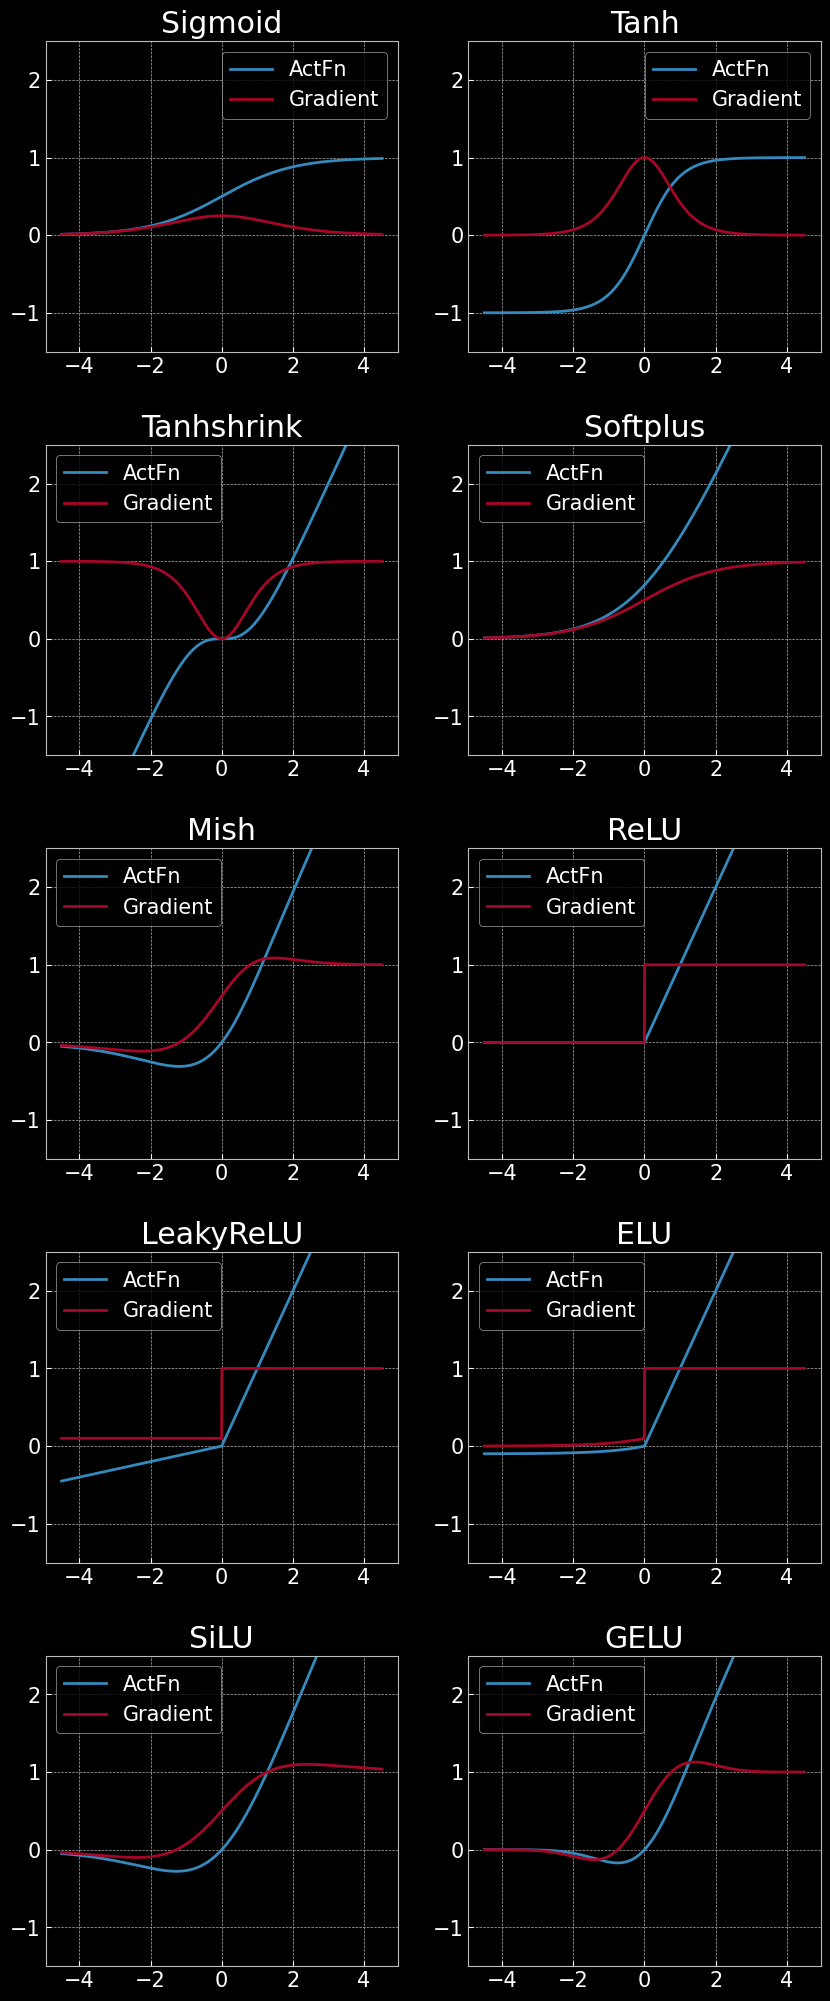

In [23]:
# NOTE: the Softmax function expects the input tensor to have at least 2 dimensions, where the second dimension represents the classes or logits
x = torch.linspace(-4.5, 4.5, 1000)

# Plotting
rows = int(np.ceil(len(act_fns) / 2.0))
fig, ax = plt.subplots(rows, 2, figsize=(10, rows*5))

for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)

fig.subplots_adjust(hspace=0.3)
plt.show()

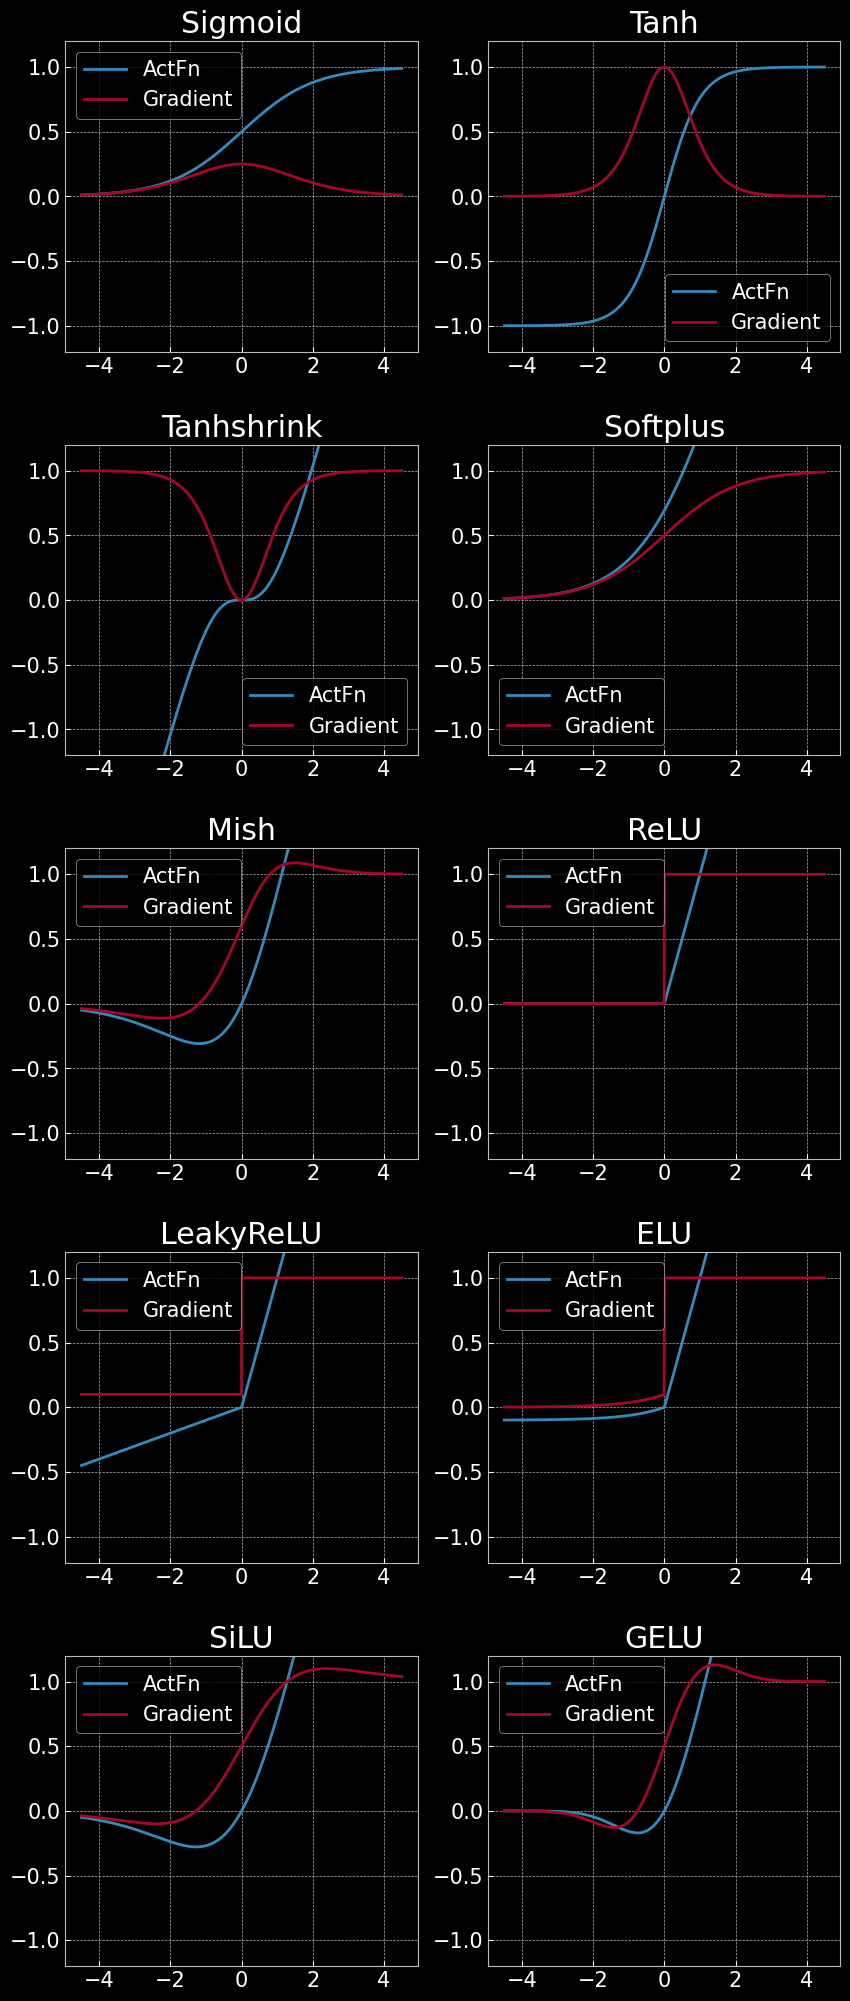

In [24]:
rows = int(np.ceil(len(act_fns) / 2.0))
fig, ax = plt.subplots(rows, 2, figsize=(10, rows*5))

for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x, lims=(-1.2, 1.2))

fig.subplots_adjust(hspace=0.3)
plt.show()

In [10]:
Softmax(dim=None).forward(torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]]))

tensor([[0.0450, 0.1224, 0.3326],
        [0.0450, 0.1224, 0.3326]])

In [36]:
cprint(Softmax)

<module> -> Softmax:
<class '__main__.Softmax'>


# Analysing the Effect of Activation Functions

In [11]:
class BaseNN(nn.Module):
    def __init__(self, act_fn, input_size=784, hidden_sizes=[512, 256, 256, 128], num_classes=10):
        super().__init__()
        
        self.act_fn = act_fn
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[layer_index-1], 
                          layer_sizes[layer_index]),
                self.act_fn
                ]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)
    
        # for their stupid loading
        # self.config = {
        #     "act_fn": act_fn, 
        #     "input_size": input_size, 
        #     "num_classes": num_classes, 
        #     "hidden_sizes": hidden_sizes
        # } 

    def forward(self, x):
        # reshape img to flat tensor
        x = x.view(-1, self.input_size)
        x = self.layers(x)
        return x
        

In [12]:
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

In [14]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(
    root=DATASET_PATH, 
    train=True, 
    download=True, 
    transform=transform
)

test_set = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform
)


In [15]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False)

val_loader = DataLoader(
    val_set, batch_size=1024, shuffle=True, drop_last=False)

test_loader = DataLoader(
    test_set, batch_size=1024, shuffle=True, drop_last=False)

# Preview FashionMNIST

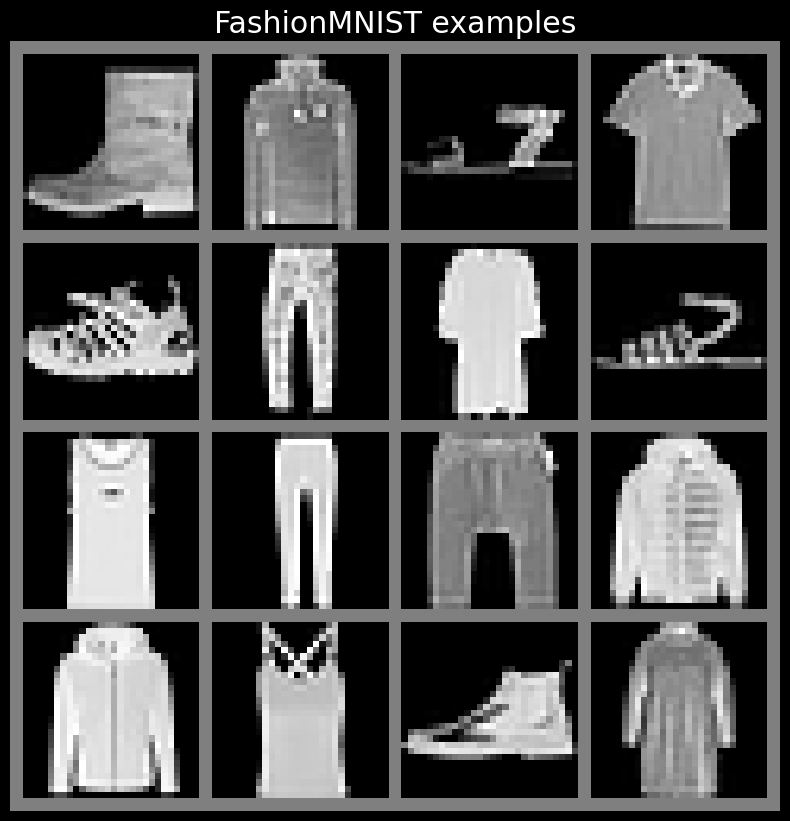

In [18]:
exmp_imgs = [train_set[i][0] for i in range(16)]

# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(
                torch.stack(exmp_imgs, dim=0), 
                nrow=4, 
                normalize=True, 
                pad_value=0.5
            )
img_grid = img_grid.permute(1, 2, 0)

plt.figure()
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [21]:
# img shape: torch.Size([1, 28, 28]), stack at dim 0
# img_grid shape: torch.Size([122, 122, 3]) = (C, H, W) to (H, W, C)
cprint(train_set[0][0].shape, img_grid.shape)

<module> -> train_set[0][0].shape:
torch.Size([1, 28, 28])
<module> -> img_grid.shape:
torch.Size([122, 122, 3])


# Visualizing the Gradient Flow after Initialization

One important aspect of activation functions is how they propagate gradients through the network, especially for the very deep NN.

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.

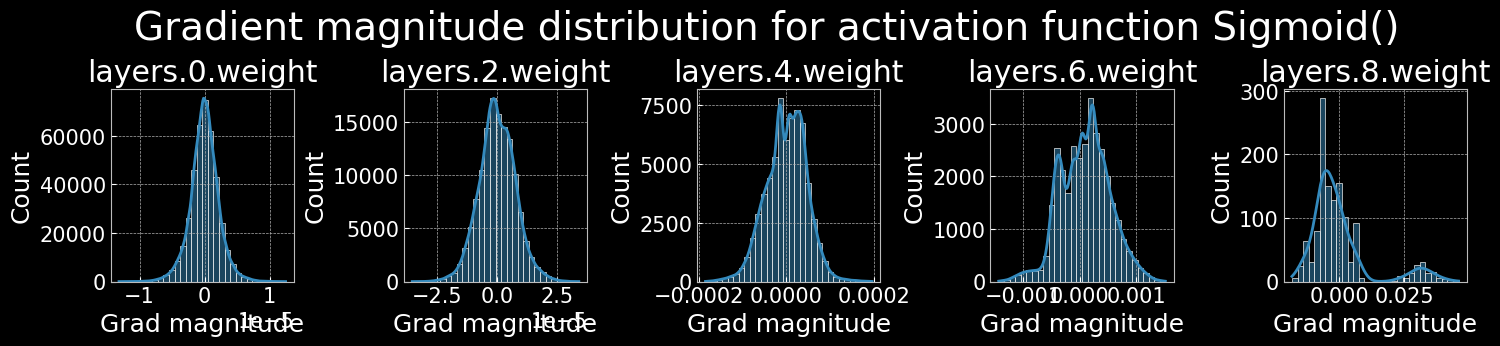

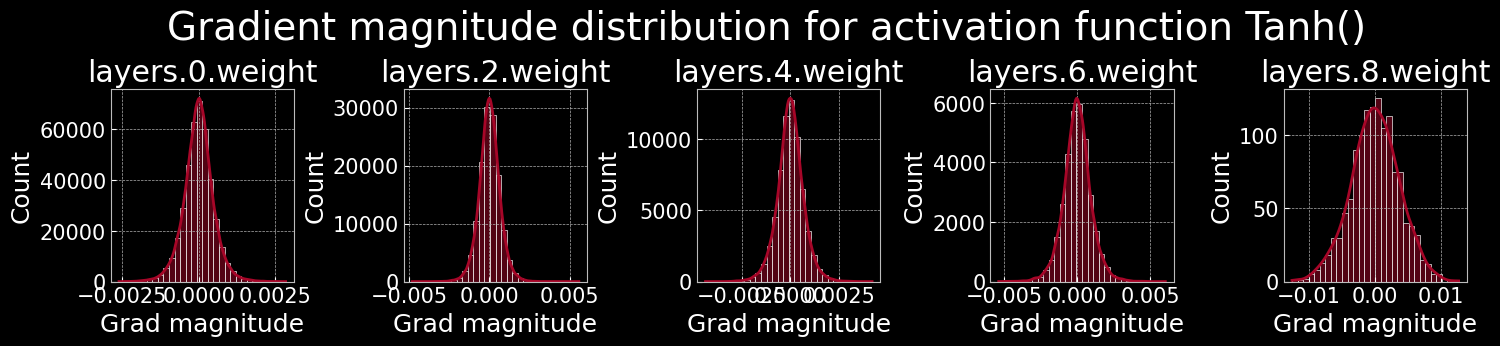

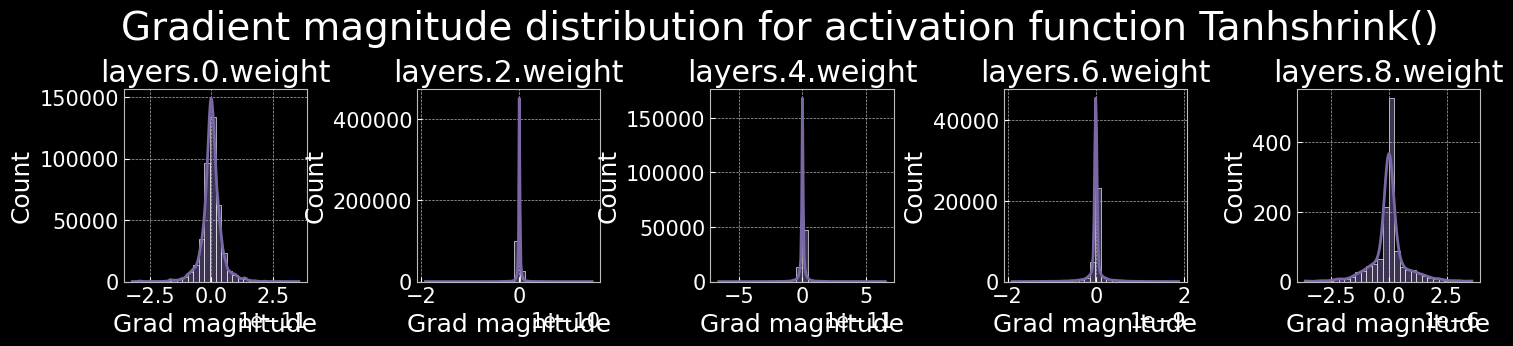

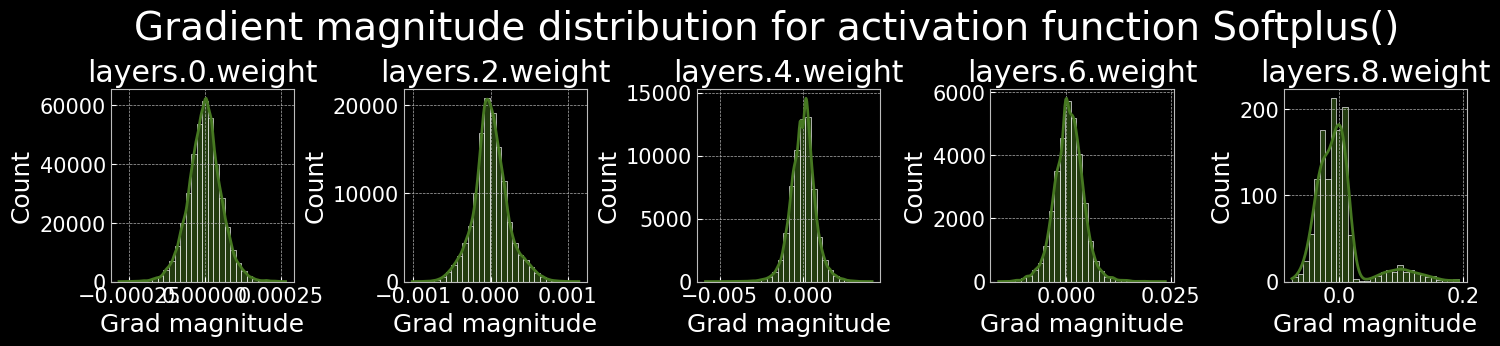

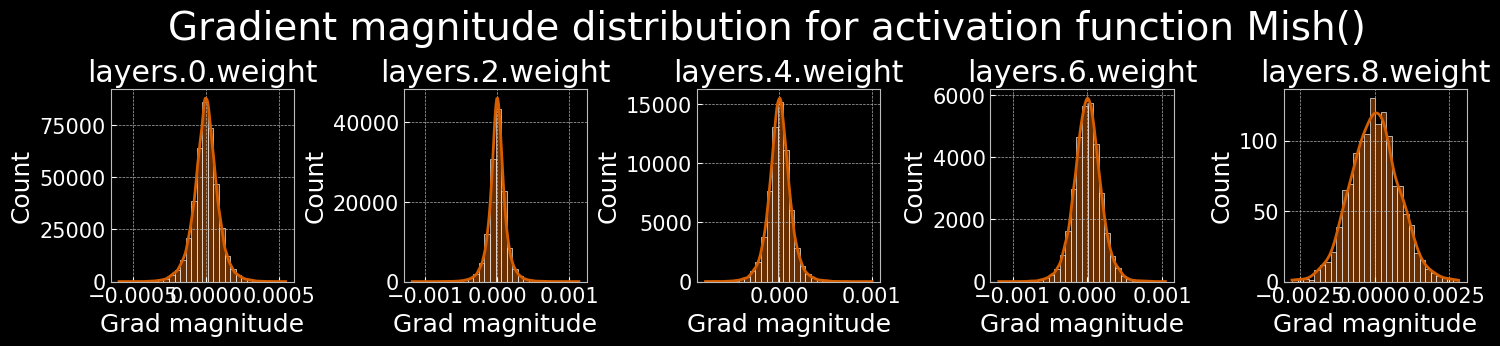

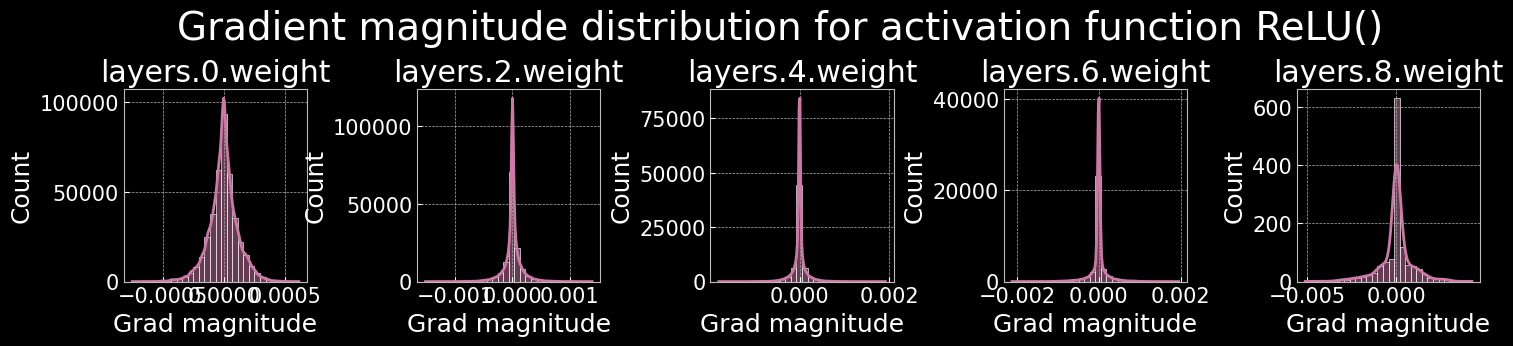

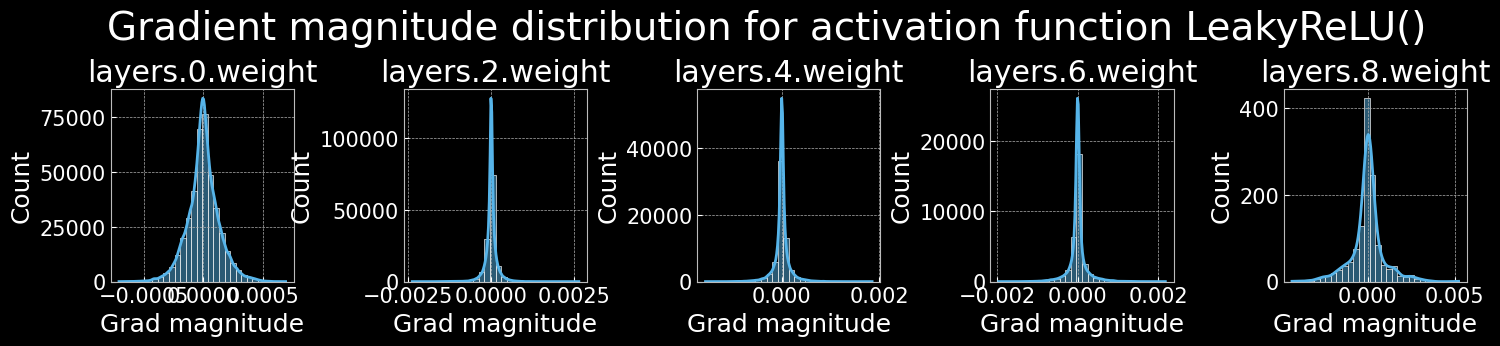

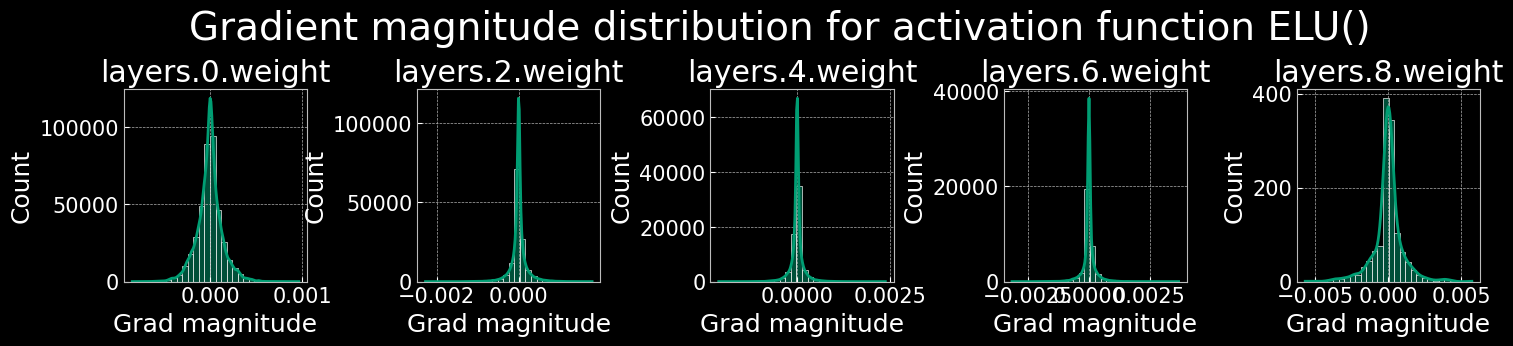

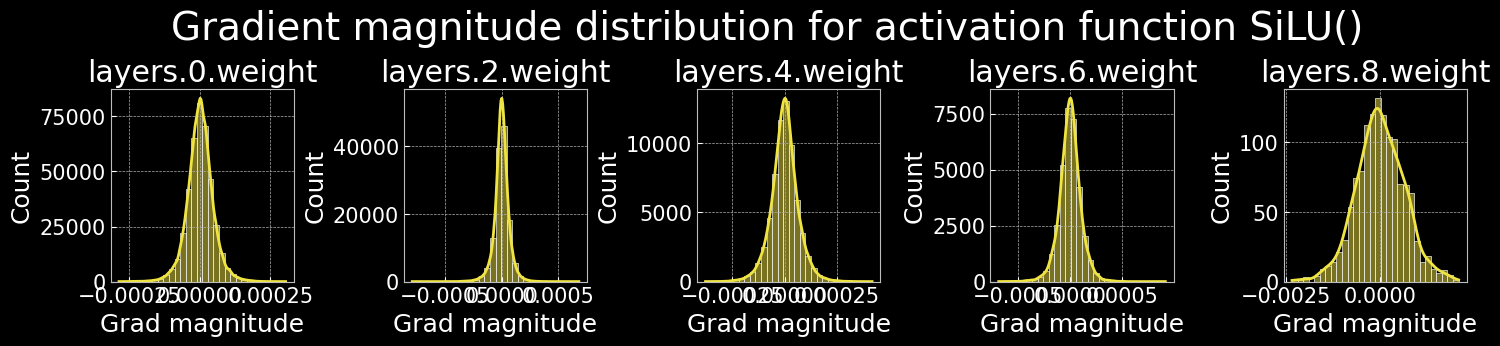

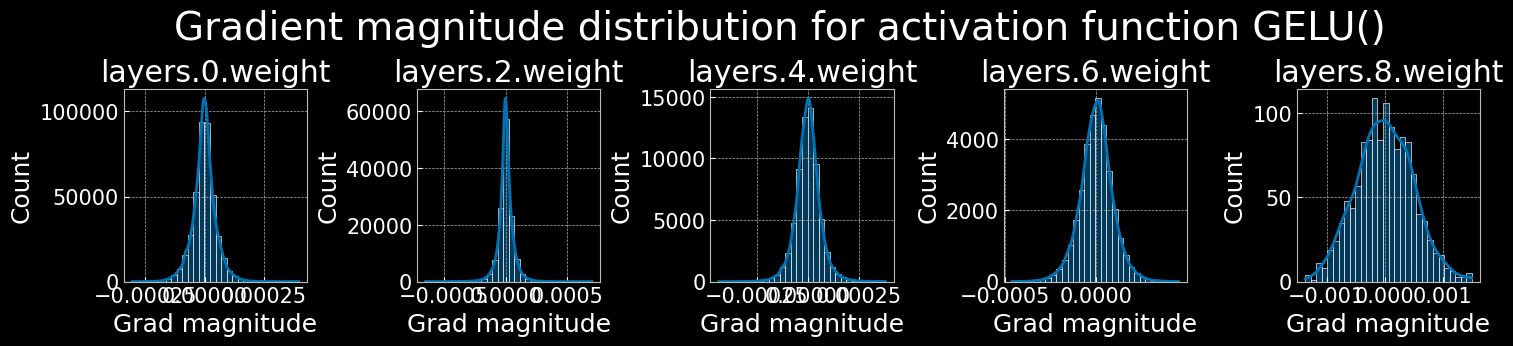

In [46]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(
            data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1

    fig.suptitle(f"Gradient magnitude distribution for activation function {net.act_fn}", fontsize=28, y=1.2)
    fig.subplots_adjust(wspace=0.6)
    plt.show()
    plt.close() 


import warnings; warnings.filterwarnings('ignore')

# Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNN(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")
    # break

# Train the NN

In [ ]:
# TODO
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 


for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNN(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

# Visualizing the Activation Distribution

In [ ]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    ## Plotting
    columns = 4
    rows = int(np.ceil(len(activations)/columns))
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title("Layer %i - %s" % (key, net.layers[key].__class__.__name__))
        fig_index += 1
    fig.suptitle("Activation distribution for activation function %s" % (net.config["act_fn"]["name"]), fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 

In [ ]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_%s" % act_fn_name).to(device)
    visualize_activations(net_actfn, color="C%i" % i)